**Minimum cost maximum flow problem**


---



For this practice we intend to perform an example of the maximum flow at minimum cost problem.  


We assume that we have a set of nodes V and a set of arcs A that relate these nodes; each of these arcs has assigned a maximum capacity for the amount of flow or load that can be sent through them. Also, each arc has its own unit cost per unit of load sent through it. This problem consists of carrying the maximum possible load from an initial node s through these arcs to another final node t at minimum cost.



First, we add the libraries we need for the problem.

In [ ]:
# Python extension to write and subsequently solve the linear programming problem designed.
!pip install ortools
from ortools.linear_solver import pywraplp

# Libraries for certain mathematical functions, representation of 2D graphics and the creation of vectors and multidimensional matrices.
import random
import matplotlib.pyplot as plt
import math
import numpy as np

# Very useful library that allows you to print to standard output or write to a text file tables with tabular data in various popular formats.
!pip install tabulate
from tabulate import tabulate

We define a function to graphically represent the nodes and arcs that we generate. Thanks to the tabulate module we also create another one to show in a table the values assigned to all of them.

In [59]:
# Visualization of our nodes and arcs generated by points
def draw(selected):

    fig, ax = plt.subplots()

    for (i,j) in selected:
      plt.plot([points[i][0],points[j][0]], [points[i][1],points[j][1]], 'g-')
    plt.plot([p[0] for p in points], [p[1] for p in points], 'co')
    
    [ax.annotate(i, (points[i][0], points[i][1])) for i in range(n) if i != s and i != t]
    ax.annotate("s", (points[s][0], points[s][1])); ax.annotate("t", (points[t][0], points[t][1]))
    plt.plot(points[s][0],points[s][1], 'rs'); plt.plot(points[t][0],points[t][1], 'rs')


# Visualization of data from our nodes and arcs generated by means of a table
def showNodesData(arcs, points, costs, capacities):

  list = []; list.append(["Source node (i):", "Destination node (j):", "Capacity:", "Unit cost:"])
  
  for (i,j) in arcs:
      if points[i][0] != points[j][0] and points[i][1] != points[j][1]:
        if i == s:
          list.append(["s", j, capacities[i,j], costs[i,j]])
        elif j == s:
          list.append([i, "s", capacities[i,j], costs[i,j]])
        elif j == t:
          list.append([i, "t", capacities[i,j], costs[i,j]])
        elif i == t:
          list.append(["t", j, capacities[i,j], costs[i,j]])
        else:
          list.append([i, j, capacities[i,j], costs[i,j]])
  
  print(tabulate(list, headers="firstrow", tablefmt="fancy_grid", showindex=False))

We defined our nodes, cost matrix and capability matrix.

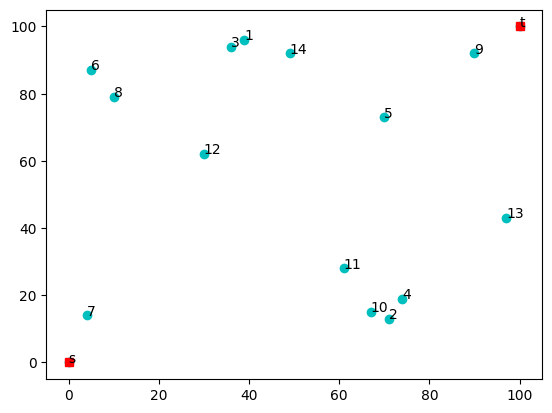

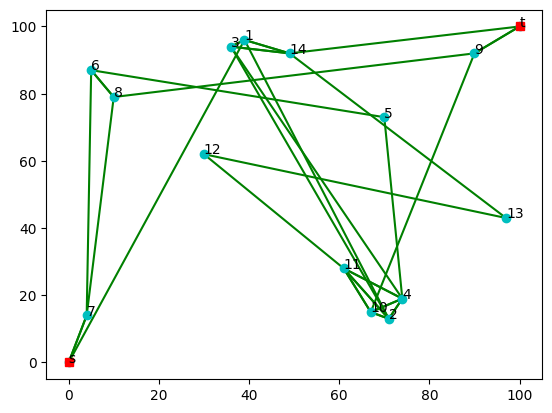

In [68]:
n = 16
v = range(n)
s = 0    # Starting node
t = n-1  # Destination node
random.seed()

# We randomly generate n points in the plane
points = [(random.randint(0, 100),random.randint(0, 100)) for i in v]
# Initial node (lower left corner)
points[0] = [0, 0] 
# End node (upper right corner)
points[n-1] = [100, 100] 

draw({})


# Cost matrix
cost =  np.zeros((n, n))
# Capabilities matrix
k =  np.zeros((n, n)) 

# Random assignment of costs and capacities
for i in v :
  for j in v:
    if j != i:
      dx = points[i][0] - points[j][0]
      dy = points[i][1] - points[j][1]
      dist = math.floor(math.sqrt(dx*dx + dy*dy)*random.uniform(1.0, 1.2))
      if dist > 20 and j != i + 1 :
        cost[i, j] = 1000
        k[i, j] = 0.0
      else :
        cost[i, j] = dist
        k[i, j] = random.randint(1, 10)
        
selected = [(i, j) for i in v for j in v if cost[i, j] < 200]
draw(selected)

We show the table of information about our generated nodes and arcs

In [69]:
showNodesData(selected, points, cost, k)

╒════════════════════╤═════════════════════════╤═════════════╤══════════════╕
│ Source node (i):   │ Destination node (j):   │   Capacity: │   Unit cost: │
╞════════════════════╪═════════════════════════╪═════════════╪══════════════╡
│ s                  │ 1                       │           5 │          117 │
├────────────────────┼─────────────────────────┼─────────────┼──────────────┤
│ s                  │ 7                       │           3 │           16 │
├────────────────────┼─────────────────────────┼─────────────┼──────────────┤
│ 1                  │ 2                       │          10 │          100 │
├────────────────────┼─────────────────────────┼─────────────┼──────────────┤
│ 1                  │ 3                       │           2 │            3 │
├────────────────────┼─────────────────────────┼─────────────┼──────────────┤
│ 1                  │ 14                      │           6 │           11 │
├────────────────────┼─────────────────────────┼─────────────┼──



---


--- 




We already have our system of nodes and arcs properly created. Now we have to set up our mathematical model and solve it. First we must solve the maximum flow problem and then obtain the minimum cost while maintaining the maximum flow.

In [70]:
# Function to show the solution obtained to the problem of maximum flow at minimum cost.
def showSolution(arcs, costs, capacities):

  solution = []; solution.append(["Source node (i):", "Destination node (j):", "Capacity:", "Unit cost:", "Flow:", "Cost:"])
  solutionArcs = []

  for i in v:
    for j in v:
      if arcs[i,j].solution_value() > 0.5:
        flowCost = costs[i,j] * arcs[i,j].solution_value()
        if i == s:
          solution.append(["s", j, capacities[i,j], costs[i,j], arcs[i,j].solution_value(), flowCost])
        elif j == t:
          solution.append([i, "t", capacities[i,j], costs[i,j], arcs[i,j].solution_value(), flowCost])
        else:
          solution.append([i, j, capacities[i,j], costs[i,j], arcs[i,j].solution_value(), flowCost])

        solutionArcs.append((i, j))

  print(tabulate(solution, headers="firstrow", tablefmt="fancy_grid", showindex=False))
  
  return solutionArcs

In [71]:
# Maximum flow problem
solver = pywraplp.Solver('Max-Flow-Problem', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# Decision variable
x = { (i,j) : solver.IntVar(0.0, solver.infinity(), 'x[%i, %i]' % (i, j)) for i in v for j in v }
z = solver.IntVar(0.0, solver.infinity(), 'z')

# Target function            
solver.Maximize(z)

# Restrictions
solver.Add(solver.Sum(x[s,j] - x[j,s] for j in v if j != s) == z)
solver.Add(solver.Sum(x[t,j] - x[j,t] for j in v if j != t) == -z)
[ solver.Add(solver.Sum(x[i,j] - x[j,i] for j in v if i != j ) == 0 ) for i in v if i != s and i != t ]
[ solver.Add(x[i,j] <= k[i,j]) for j in v for i in v ]
    
solver.Solve()

maxFlow = solver.Objective().Value()
print('Maximum flow value: ', maxFlow)

Maximum flow value:  8.0


╒════════════════════╤═════════════════════════╤═════════════╤══════════════╤═════════╤═════════╕
│ Source node (i):   │ Destination node (j):   │   Capacity: │   Unit cost: │   Flow: │   Cost: │
╞════════════════════╪═════════════════════════╪═════════════╪══════════════╪═════════╪═════════╡
│ s                  │ 1                       │           5 │          117 │       5 │     585 │
├────────────────────┼─────────────────────────┼─────────────┼──────────────┼─────────┼─────────┤
│ s                  │ 7                       │           3 │           16 │       3 │      48 │
├────────────────────┼─────────────────────────┼─────────────┼──────────────┼─────────┼─────────┤
│ 1                  │ 3                       │           2 │            3 │       1 │       3 │
├────────────────────┼─────────────────────────┼─────────────┼──────────────┼─────────┼─────────┤
│ 1                  │ 14                      │           6 │           11 │       4 │      44 │
├───────────────────

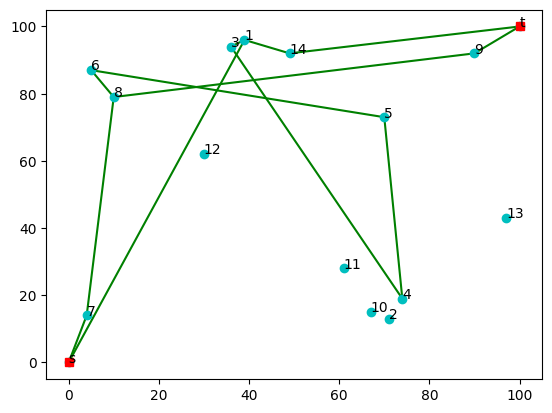

In [72]:
# Minimum cost maximum flow problem
solver2 = pywraplp.Solver('Max-Flow-Minimum-Cost-Problem', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# Decision variables
f = { (i,j) : solver2.IntVar(0.0, k[i,j], 'f[%i, %i]' % (i, j)) for i in v for j in v }

# Target function
solver2.Minimize(solver2.Sum(cost[i,j] * f[i,j]  for i in v for j in v if i != j ))

# Restrictions
solver2.Add(solver2.Sum(f[s, i] - f[i, s] for i in v if i != s) == maxFlow)
solver2.Add(solver2.Sum(f[t, i] - f[i, t] for i in v if i != t) == -maxFlow)
[ solver2.Add(solver2.Sum(f[i, j] - f[j, i] for i in v ) == 0 ) for j in v if j != s and j != t ]
[ solver2.Add(f[i, j] <= k[i,j]) for j in v for i in v ]


solver2.Solve()
solutionArcs = showSolution(f, cost, k)
draw(solutionArcs)
print("\n\nMinimum cost value: ", solver2.Objective().Value(), "\n\n")